In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import elastic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis import inversion
import plotting

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Helper functions

In [2]:
def make_random_ela_model(shape,seed=113,vs_min=600,vs_trend=0.32,v_s_var=1000, vp_vs_ratio=1.8):
    n_x, n_z = shape
    np.random.seed(seed)

    v_s = vs_min + vs_trend * np.arange(n_z) + v_s_var * (np.random.rand(n_z) - 0.5)
    v_s = ndimage.gaussian_filter(v_s,1,mode='nearest')
    v_s = np.pad(np.expand_dims(v_s,axis=0),((n_x-1,0),(0,0)),mode='edge')

    v_p = v_s * vp_vs_ratio
    rho = 310 * v_p**0.25
    
    return np.concatenate([np.expand_dims(v_p,axis=0),
                           np.expand_dims(v_s,axis=0),
                           np.expand_dims(rho,axis=0)],axis=0)
    
def myround(x, base=5):
    return (base * (np.array(x) / base).round())

## Make "random" 1.5d model and src/rec geometry

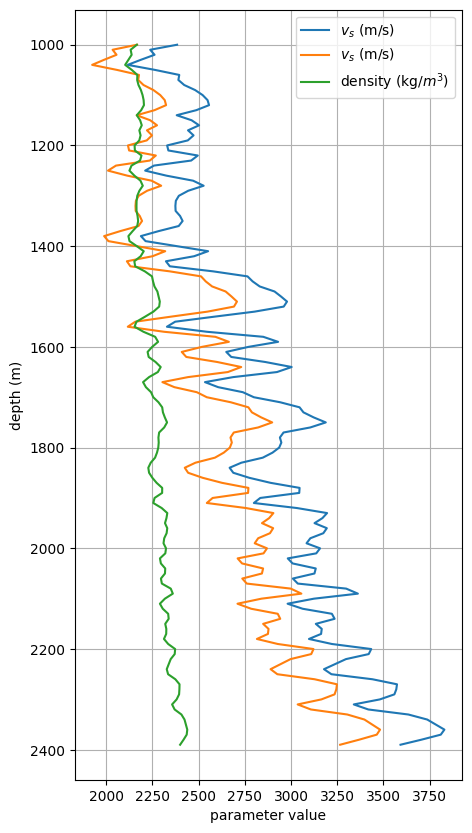

In [3]:
n_x, n_z = 100, 140
d_x = d_z = 10.0
o_x, o_z = 0.0, 1000.0

#create model
ela_model = make_random_ela_model((n_x,n_z),vs_min=2000,vp_vs_ratio=1.1,vs_trend=8)
ela_model[ela_model<1900.0] = 1900.0

plt.figure(figsize=(5,10))
labels = ['$v_s$ (m/s)','$v_s$ (m/s)','density (kg/$m^3$)']
for model, label in zip(ela_model, labels):
    plt.plot(model[0],o_z + d_z * np.arange(n_z),label=label)
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
_ = plt.ylabel('depth (m)')
_ = plt.xlabel('parameter value')

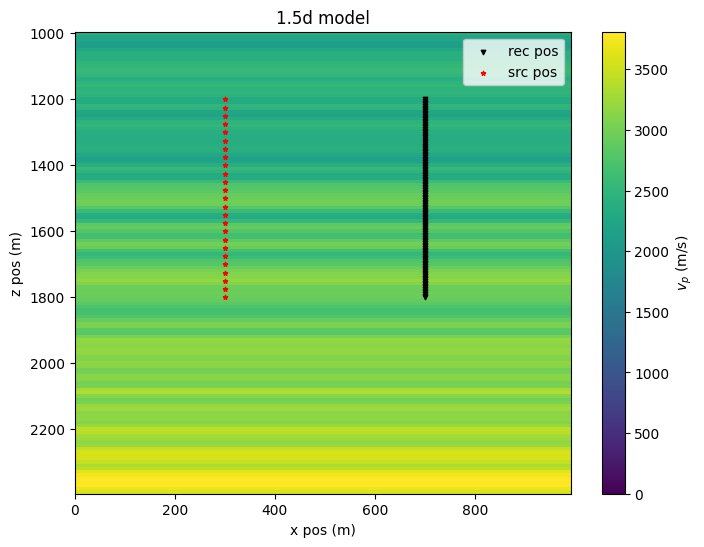

In [4]:
# create source and receiver geometry
rec_top_depth = 1200.0
rec_bot_depth = 1800.0
rec_spacing = 5.0
rec_x_pos = 700.0
z_rec = np.arange(rec_top_depth,rec_bot_depth+rec_spacing,rec_spacing)
x_rec = rec_x_pos * np.ones_like(z_rec) 
recs = np.array([x_rec, z_rec]).T

src_top_depth = 1200.0
src_bot_depth = 1800.0
src_spacing = 25.0
src_x_pos = 300.0
z_src = np.arange(src_top_depth,src_bot_depth+src_spacing,src_spacing)
x_src = src_x_pos * np.ones_like(z_src) 
srcs = np.array([x_src, z_src]).T

#plot 
plotting.plot_model(ela_model[0],
                   title='1.5d model', 
                   cbar=True,
                   sampling=(d_x,d_z),
                   origins = (o_x,o_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

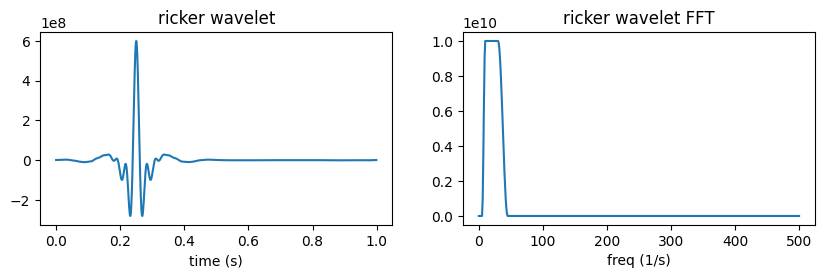

In [5]:
# make an explosive Trapezoid wavelet
n_t = 1000
d_t = 0.001
f_1 = 5 # 30.0
f_2 = 10 # 150.0
f_3 = 30 # 250.0
f_4 = 45 # 350.0
delay = 0.25
wavelets = Elastic2D.ElasticIsotropicTrapezoid2D(n_t, d_t, f_1, f_2, f_3, f_4, delay).arr
scale=1e10 
wavelets*=scale

plotting.plot_wavelet(wavelets[2],d_t,title='ricker wavelet')

In [6]:
# make 2d acoustic wave equation solver
elastic_2d = elastic_isotropic.ElasticIsotropic2D(
  model=ela_model,
  model_sampling=(d_x, d_z),
  model_origins=(o_x, o_z),
  model_padding=(50, 50),
  wavelet=wavelets,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3],
  recording_components=['vx','vz'],
subsampling=5)

CPU times: user 24.4 s, sys: 1.93 s, total: 26.3 s
Wall time: 4.23 s


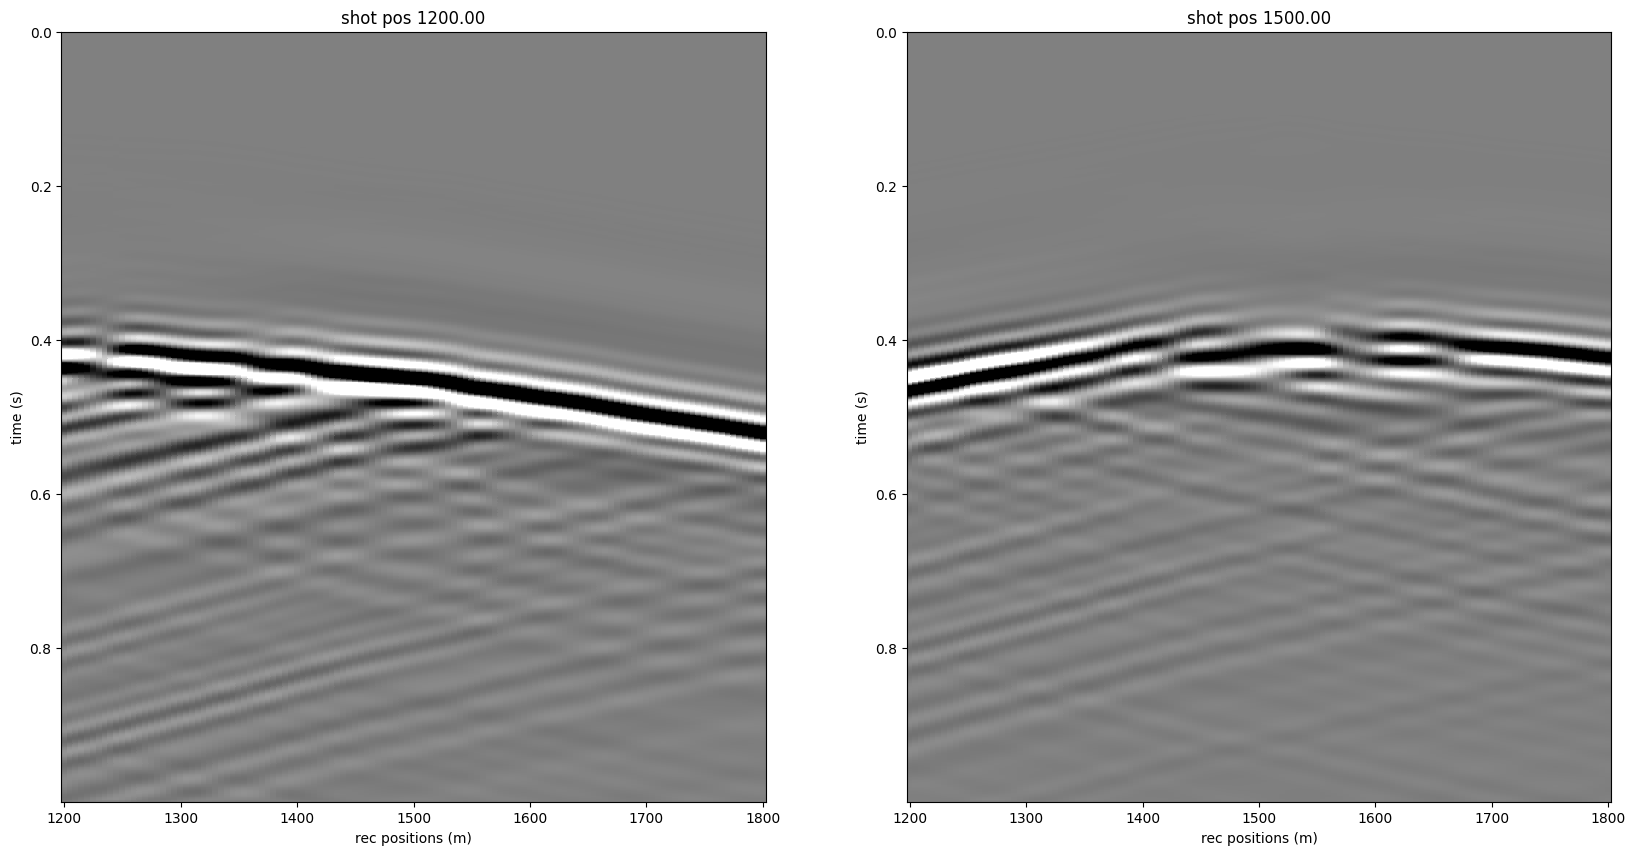

In [7]:
%%time
data_obs = elastic_2d.forward(ela_model)

plotting.plot_data(data_obs[:,1],
                   d_t,
                   n_shots=2,
                   src_locations=z_src,
                   rec_locations=z_rec,
                   pclip=98,
                   figsize=(10, 10),)

## make FWI starting model

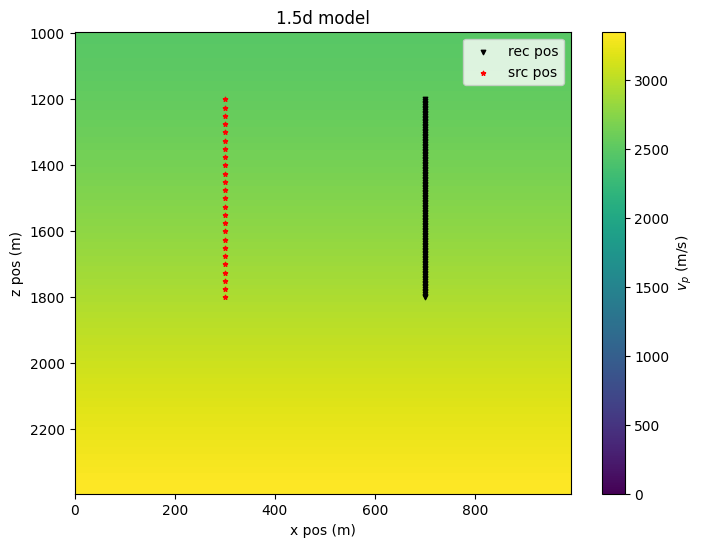

In [8]:
starting_model = ndimage.gaussian_filter(ela_model, (0, 50, 50), mode='nearest')

plotting.plot_model(starting_model[0],
                   title='1.5d model', 
                   cbar=True,
                   sampling=(d_x,d_z),
                   origins = (o_x,o_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

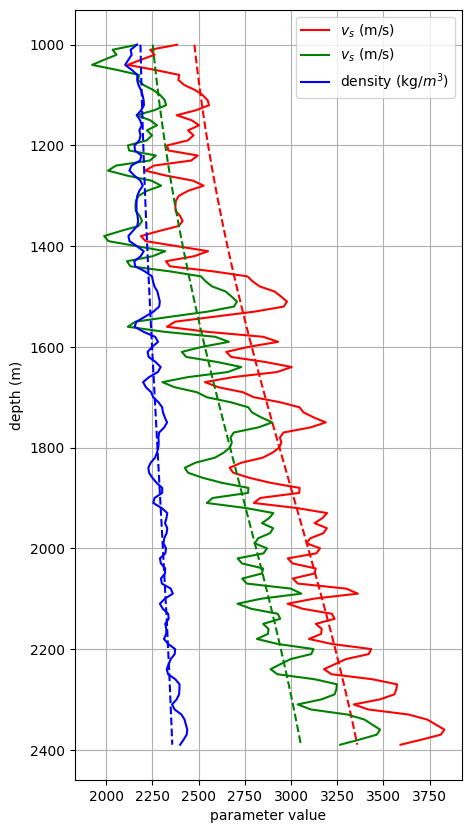

In [41]:
plt.figure(figsize=(5,10))
labels = ['$v_s$ (m/s)','$v_s$ (m/s)','density (kg/$m^3$)']
colors = ['r','g','b']
for model, start_mod, label, color in zip(ela_model, starting_model, labels, colors):
    plt.plot(model[0],o_z + d_z * np.arange(n_z),label=label, color=color)
    plt.plot(start_mod[0],o_z + d_z * np.arange(n_z), color=color,linestyle='--')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
_ = plt.ylabel('depth (m)')
_ = plt.xlabel('parameter value')

## Make a gradient mask

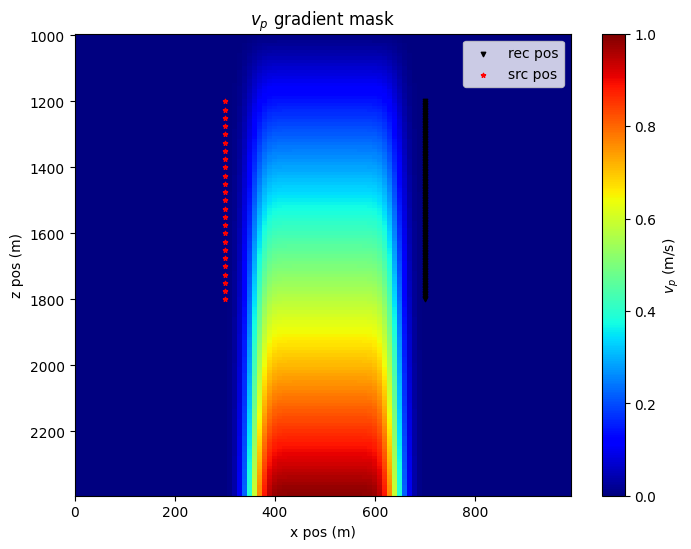

In [10]:
# mask of 1.0's the size of the elastic model
gradient_mask = np.ones_like(ela_model)

# make mask zero to the left of srcs and right of receivers
x_buffer = 50.0
for i_x in range(n_x):
    x = o_x + i_x * d_x
    if x <= src_x_pos + x_buffer or x >= rec_x_pos - x_buffer:
        gradient_mask[:,i_x,:] *= 0.0

# scale with depth
gradient_mask *= np.arange(n_z)/n_z      

# smooth
gradient_mask = ndimage.gaussian_filter(gradient_mask,(0,2,2))

# plot
plotting.plot_model(gradient_mask[0],
                   title='$v_p$ gradient mask',
                   cbar=True,
                   sampling=(d_x,d_z),
                    origins=(o_x,o_z),
                   cmap='jet',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6),
                   vlims=[0,1])

In [11]:
!rm /tmp/*.H@
!rm wrk/crosswell_ela*

In [12]:
fwi_prob = inversion.Fwi(elastic_2d,
                         data_obs,
                         starting_model,
                         solver_type='nlcg',
                         num_iter=50,
                         iterations_per_save=5,
                         prefix='crosswell_ela',
                         # model_bounds=[1500.0,4500.0],
                         gradient_mask = gradient_mask)

In [13]:
%%time

history = fwi_prob.run()

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 
	Restart folder: /tmp/restart_2023-01-26T17-15-01.286439/
	Conjugate method used: FR
##########################################################################################

iter = 00, obj = 2.79541e-04, resnorm = 2.36e-02, gradnorm = 9.84e-09, feval = 1, geval = 1
iter = 01, obj = 2.09971e-04, resnorm = 2.05e-02, gradnorm = 1.11e-08, feval = 4, geval = 2
iter = 02, obj = 1.77195e-04, resnorm = 1.88e-02, gradnorm = 1.44e-08, feval = 9, geval = 3
iter = 03, obj = 1.55233e-04, resnorm = 1.76e-02, gradnorm = 1.43e-08, feval = 12, geval = 4
iter = 04, obj = 1.19199e-04, resnorm = 1.54e-02, gradnorm = 1.20e-08, feval = 15, geval = 5
iter = 05, obj = 1.04584e-04, resnorm = 1.45e-02, gradnorm = 9.90e-09, feval = 18, geval = 6
iter = 06, obj = 9.24107e-05, resnorm = 1.36e-02, gradnorm = 7.71e-09, feval = 21, geval = 7
iter = 07, obj = 8.21589e-05, resnorm = 1.2

## Plot objective function as a function of iteration

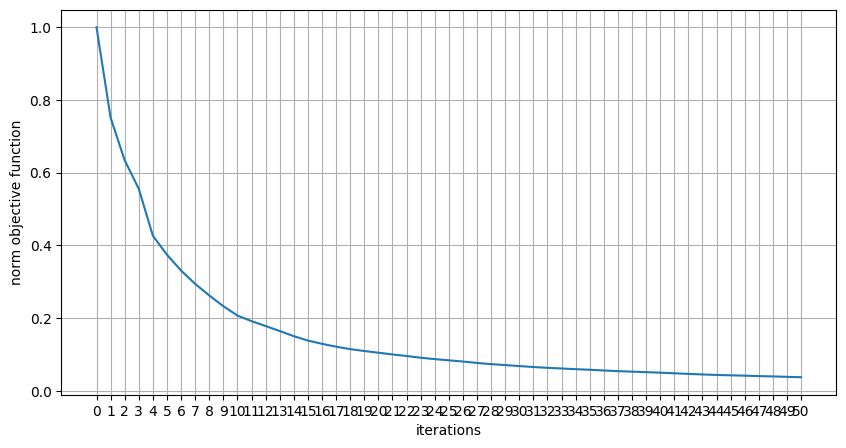

In [36]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

## Plot inverted model and difference w.r.t. starting model

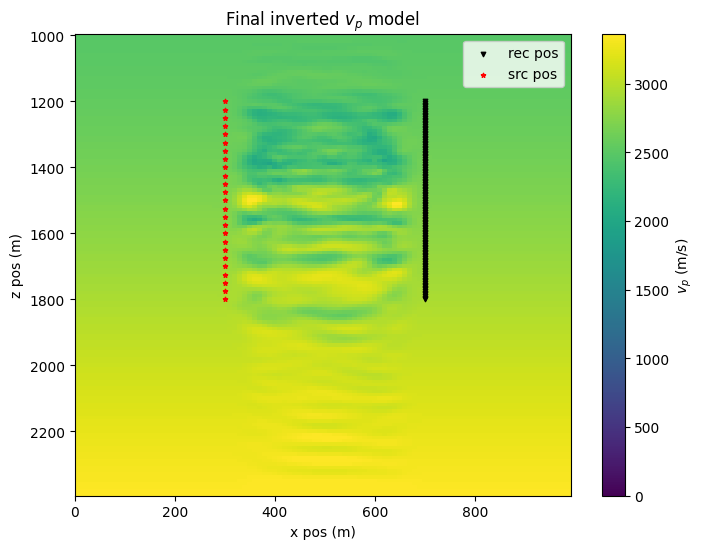

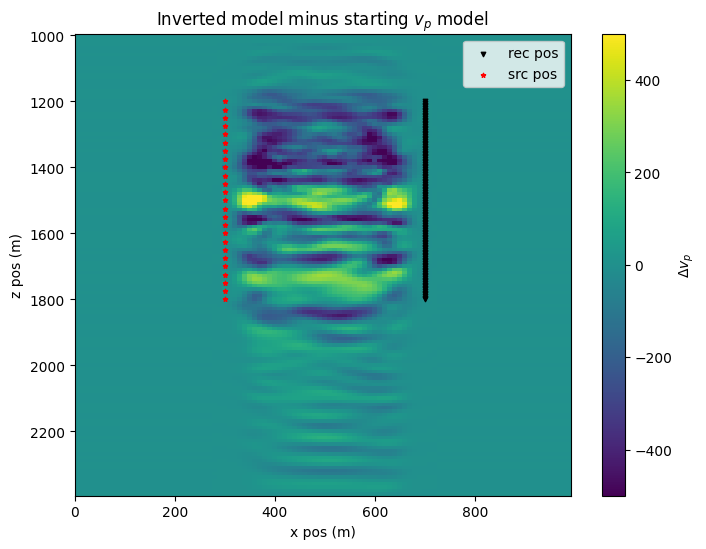

In [39]:
plotting.plot_model(history['inv_mod'][0],
                   title='Final inverted $v_p$ model',
                   cbar=True,
                   sampling=(d_x,d_z),
                   origins=(o_x,o_z),
                   cmap='viridis',
                   src_locations=srcs,
                   rec_locations=recs,
                   figsize=(8,6))

plotting.plot_model(history['inv_mod'][0]-starting_model[0],
           title='Inverted model minus starting $v_p$ model',
           cbar=True,
           cbar_label='$\Delta v_p$',
           sampling=(d_x,d_z),
           origins=(o_x,o_z),
           cmap='viridis',
           src_locations=srcs,
           rec_locations=recs,
           figsize=(8,6),
           vlims=[-500,500])

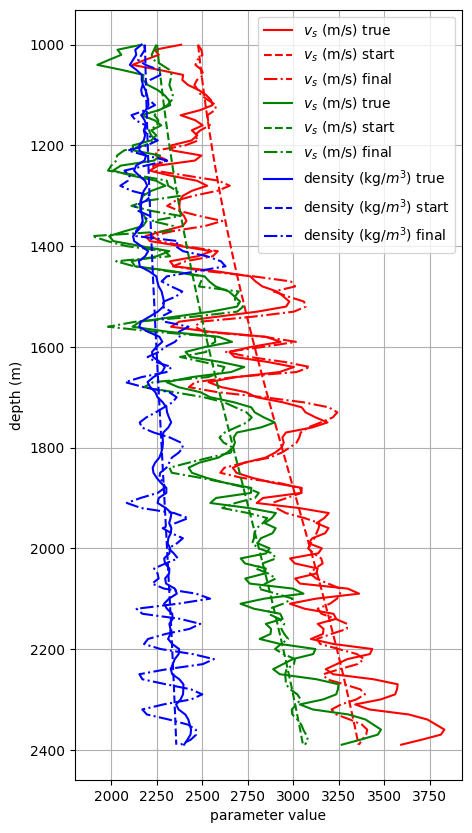

In [46]:
plt.figure(figsize=(5,10))
labels = ['$v_s$ (m/s)','$v_s$ (m/s)','density (kg/$m^3$)']
colors = ['r','g','b']
for model, start_mod, inv_model, label, color in zip(ela_model, starting_model, history['inv_mod'], labels, colors):
    plt.plot(model[n_x//2],o_z + d_z * np.arange(n_z),label=f'{label} true', color=color)
    plt.plot(start_mod[n_x//2],o_z + d_z * np.arange(n_z),label=f'{label} start', color=color,linestyle='--')
    plt.plot(inv_model[n_x//2],o_z + d_z * np.arange(n_z),label=f'{label} final', color=color,linestyle='dashdot')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
_ = plt.ylabel('depth (m)')
_ = plt.xlabel('parameter value')

## Compare first and last FWI residuals

In [50]:
history['residual'].shape

(11, 25, 2, 121, 1000)

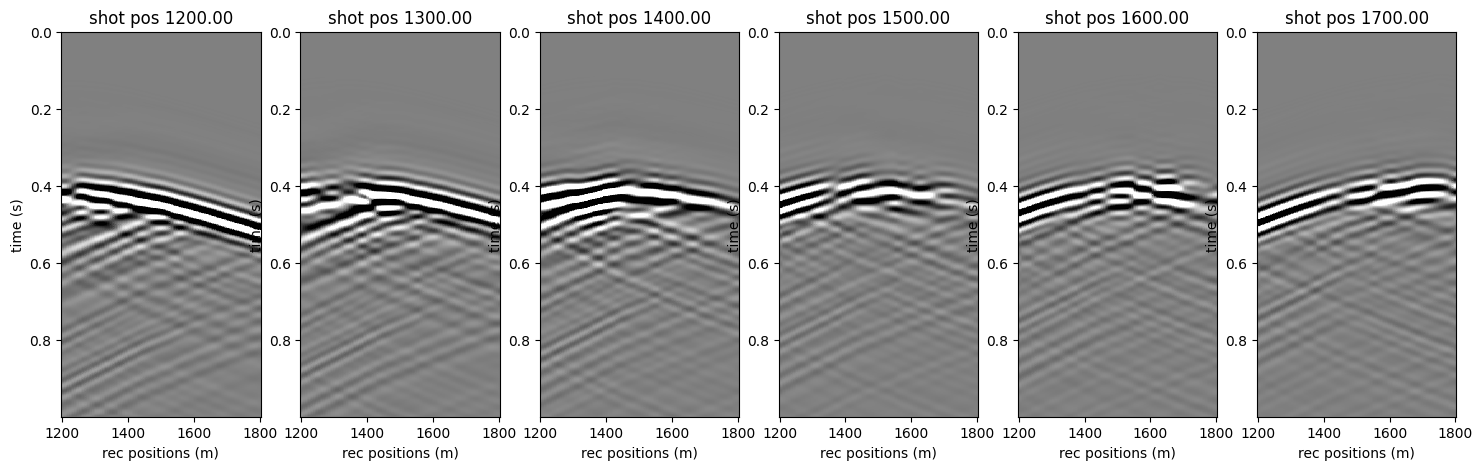

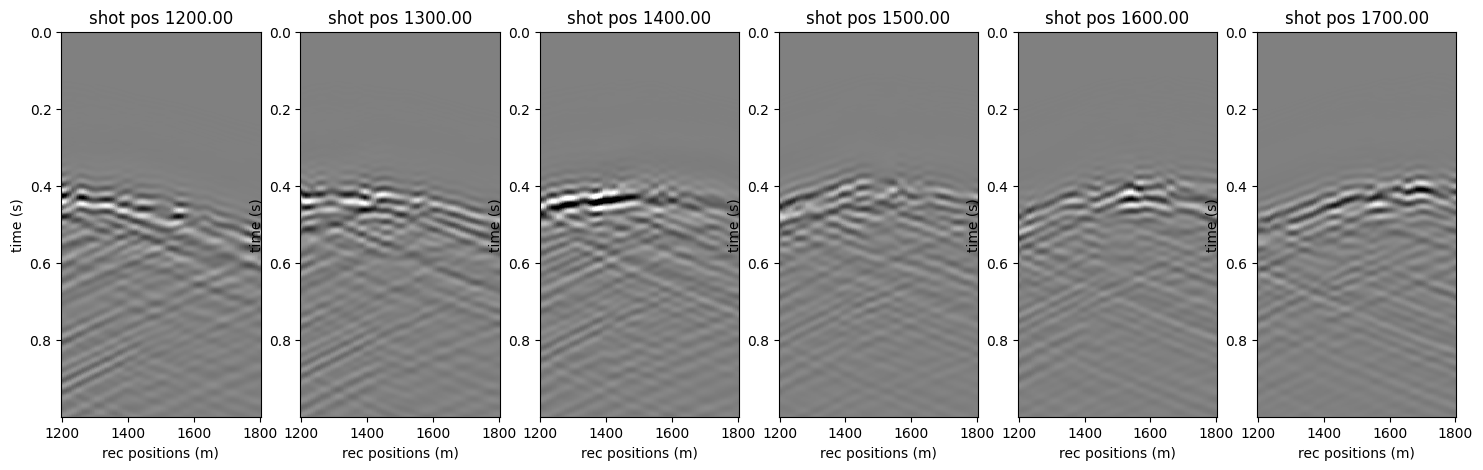

In [52]:
component = 1
clip = np.percentile(np.abs(history['residual'][:,:,component]),99)

#first residual
first_residual = history['residual'][0]
plotting.plot_data(first_residual[:,component],
          d_t,
          src_locations=z_src,
          rec_locations=z_rec,
          clip=clip)

# final residual
final_residual = history['residual'][-1]
plotting.plot_data(final_residual[:,component],
          d_t,
          src_locations=z_src,
          rec_locations=z_rec,
          clip=clip)


# To load previous results you can load the history dictionary with the cells below

In [3]:
history_load = inversion.load_history('wrk', 'crosswell_ela')

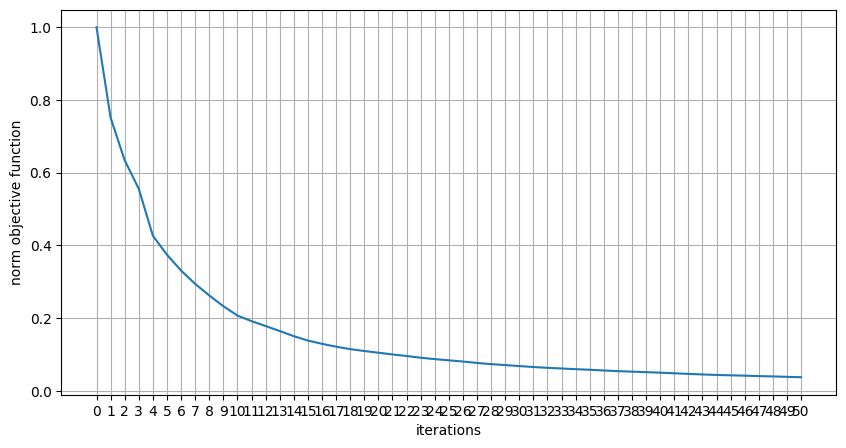

In [4]:
obj_func = history_load['obj']

fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()